# Dynamic Programming

We will be using dynamic programming on sample 4x4 grid world and study **Policy Evaluation** 

![GridWorld](./figs/gridworld.png "Grid World")


### Value Iteration 

Value Iteration is carried out by repeatedly applying equation (3.8) from text in a loop till change in state values fall below a threshold. Pseudo code for the algorithm is given in Fig 3-5 in the text.

#### Running in Colab/Kaggle

If you are running this on Colab, please uncomment below cell and run this to install required dependencies.

In [ ]:
## Uncomment and execute this cell to install all the the dependencies if running in Google Colab or Kaggle

## Uncomment and run for Colab
# !git clone https://github.com/nsanghi/drl-2ed
# %cd /content/drl-2ed 
# %cd chapter3


## Uncomment and run for Kaggle
# !git clone https://github.com/nsanghi/drl-2ed
# %cd /content/drl-2ed 
# %cd chapter3

In [1]:
# Initial imports and environment setup
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

# create grid world environment
from gridworld_mbased import GridworldEnv
env = GridworldEnv()

In [2]:
# Custom print to show state values inside the grid
def grid_print(V, k=None):
    ax = sns.heatmap(V.reshape(env.shape),
                     annot=True, square=True,
                     cbar=False, cmap='Blues',
                     xticklabels=False, yticklabels=False)

    if k:
        ax.set(title="State values after K = {0}".format(k))
    else:
        ax.set(title="State Values".format(k))
    plt.show()

In [3]:
# Value Iteration
def value_iteration(env, discount_factor=1.0, theta=0.00001):
    """
    Carry out Value iteration given an environment and a full description
    of the environment's dynamics.

    Args:
        env: OpenAI env. env.P -> transition dynamics of the environment.
            env.P[s][a] [(prob, next_state, reward, done)].
            env.nS is number of states in the environment.
            env.nA is number of actions in the environment.
        discount_factor: Gamma discount factor.
        theta: tolernace level to stop the iterations

    Returns:
        policy: [S, A] shaped matrix representing optimal policy.
        value : [S] length vector representing optimal value
    """

    def argmax_a(arr):
        """
        Return idx of max element in an array.
        """
        max_idx = []
        max_val = float('-inf')
        for idx, elem in enumerate(arr):
            if elem == max_val:
                max_idx.append(idx)
            elif elem > max_val:
                max_idx = [idx]
                max_val = elem
        return max_idx

    optimal_policy = np.zeros([env.nS, env.nA])
    V = np.zeros(env.nS)
    V_new = np.copy(V)

    while True:
        delta = 0
        # For each state, perform a "greedy backup"
        for s in range(env.nS):
            q = np.zeros(env.nA)
            # Look at the possible next actions
            for a in range(env.nA):
                # For each action, look at the possible next states
                # to calculate q[s,a]
                for prob, next_state, reward, done in env.P[s][a]:
                    # Calculate the value for each action as per backup diagram
                    if not done:
                        q[a] += prob*(reward + discount_factor * V[next_state])
                    else:
                        q[a] += prob * reward

            # find the maximum value over all possible actions
            # and store updated state value
            V_new[s] = q.max()
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(V_new[s] - V[s]))

        V = np.copy(V_new)

        # Stop if change is below a threshold
        if delta < theta:
            break

    # V(s) has optimal values. Use these values and one step backup
    # to calculate optimal policy
    for s in range(env.nS):
        q = np.zeros(env.nA)
        # Look at the possible next actions
        for a in range(env.nA):
            # For each action, look at the possible next states
            # and calculate q[s,a]
            for prob, next_state, reward, done in env.P[s][a]:

                # Calculate the value for each action as per backup diagram
                if not done:
                    q[a] += prob * (reward + discount_factor * V[next_state])
                else:
                    q[a] += prob * reward

        # find the optimal actions
        # We are returning stochastic policy which will assign equal
        # probability to all those actions which are equal to maximum value
        best_actions = argmax_a(q)
        optimal_policy[s, best_actions] = 1.0 / len(best_actions)

    return optimal_policy, V

Optimal Policy
 [[0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.5  0.5 ]
 [1.   0.   0.   0.  ]
 [0.5  0.   0.   0.5 ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.5  0.5  0.  ]
 [0.   0.   1.   0.  ]
 [0.5  0.5  0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]]


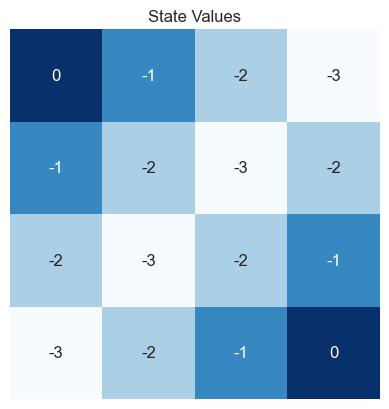

In [4]:
# Run policy iteration on Grid world
pi_star, V_star = value_iteration(env)

# Print Optimal policy
print("Optimal Policy\n", pi_star)

# Print optimal state values
grid_print(V_star.reshape(env.shape))

### Conclusion

Similar to Policy Iteration in `listing3_3`, we see that optimal state values are negative of number of steps required to each the closest terminal state. As the reward is -1 for each time step till agent reaches terminal state, the optimal policy would take the agent to terminal state in minimal number of possible steps. For some states, more than one action could lead to same number of steps to reach terminal state. For example, look at top right state with value=-3, it takes 3 steps to reach the terminal state at top-left or terminal state at bottom-right. In other words, the state values is negative of Manhattan distance between the state and nearest terminal state.